In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam


# 1. Load data
df = pd.read_csv("C:\\Users\\Admin\\Desktop\\Volve Field\\NO_15_9-F-1_C.csv")

features = ["AVG_DOWNHOLE_PRESSURE", "AVG_DOWNHOLE_TEMPERATURE", "BORE_OIL_VOL", 
            "BORE_GAS_VOL", "BORE_WAT_VOL", "AVG_CHOKE_SIZE_P", 
            "ON_STREAM_HRS"]
target = ["AVG_DOWNHOLE_PRESSURE"]

data = df[features + target].dropna()

# 2. Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

X_all = scaled[:, :-1]
y_all = scaled[:, -1]

# 3. Tạo sequences
def create_sequences(X, y, seq_len=14):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 14
X, y = create_sequences(X_all, y_all, SEQ_LEN)

# Train/Val/Test split
n = len(X)
train_size = int(n*0.4)
val_size = int(n*0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

# 4. Define model (ví dụ GRU)
model = Sequential([
    SimpleRNN(64, input_shape=(SEQ_LEN, X.shape[2])),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(0.001), loss='mse')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=8, verbose=1)

# 5. Evaluate
y_pred = model.predict(X_test)

# Reverse scaling để so sánh
y_test_real = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test), X.shape[2])), y_test.reshape(-1,1)], axis=1)
)[:,-1]

y_pred_real = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred), X.shape[2])), y_pred], axis=1)
)[:,-1]


Epoch 1/100


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1846 - val_loss: 0.0250
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0089
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0082
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0057
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0091
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_l

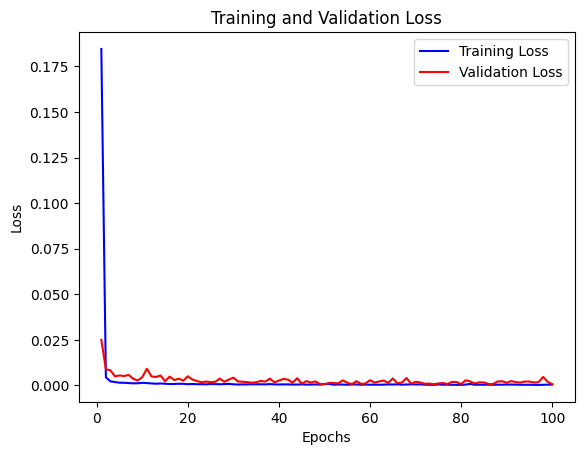

In [5]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

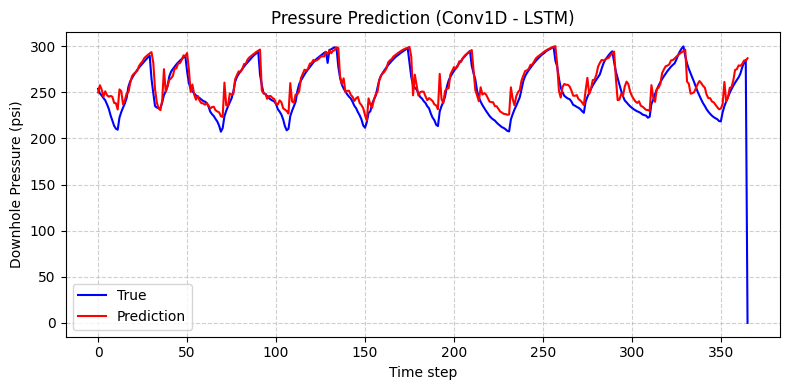

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử đã có:
# y_test_real : giá trị thực (after inverse_transform)
# y_pred_real : giá trị dự đoán
# train_size, val_size, test_size : số lượng mẫu tương ứng

plt.figure(figsize=(8,4))

# Vẽ đường True
plt.plot(y_test_real, label="True", color="blue")

# Vẽ đường Prediction
plt.plot(y_pred_real, label="Prediction", color="red")

# Format biểu đồ
plt.xlabel("Time step")
plt.ylabel("Downhole Pressure (psi)")
plt.title("Pressure Prediction (Conv1D - LSTM)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
def rse(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return numerator / denominator

def rae(y_true, y_pred):
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    return numerator / denominator

# Sau khi inverse_transform
y_true = y_test_real
y_pred = y_pred_real

rse_score = rse(y_true, y_pred)
rae_score = rae(y_true, y_pred)

print("RSE:", rse_score)
print("RAE:", rae_score)

RSE: 0.37393206124233264
RAE: 0.35287249153266964
